### data: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce?select=olist_geolocation_dataset.csv

In [174]:
import csv
from dotenv import load_dotenv
import os
import pymysql
import pandas as pd
import numpy as np
import math
from IPython.display import Image, display
import gc
import seaborn as sns
import matplotlib.pyplot as plt

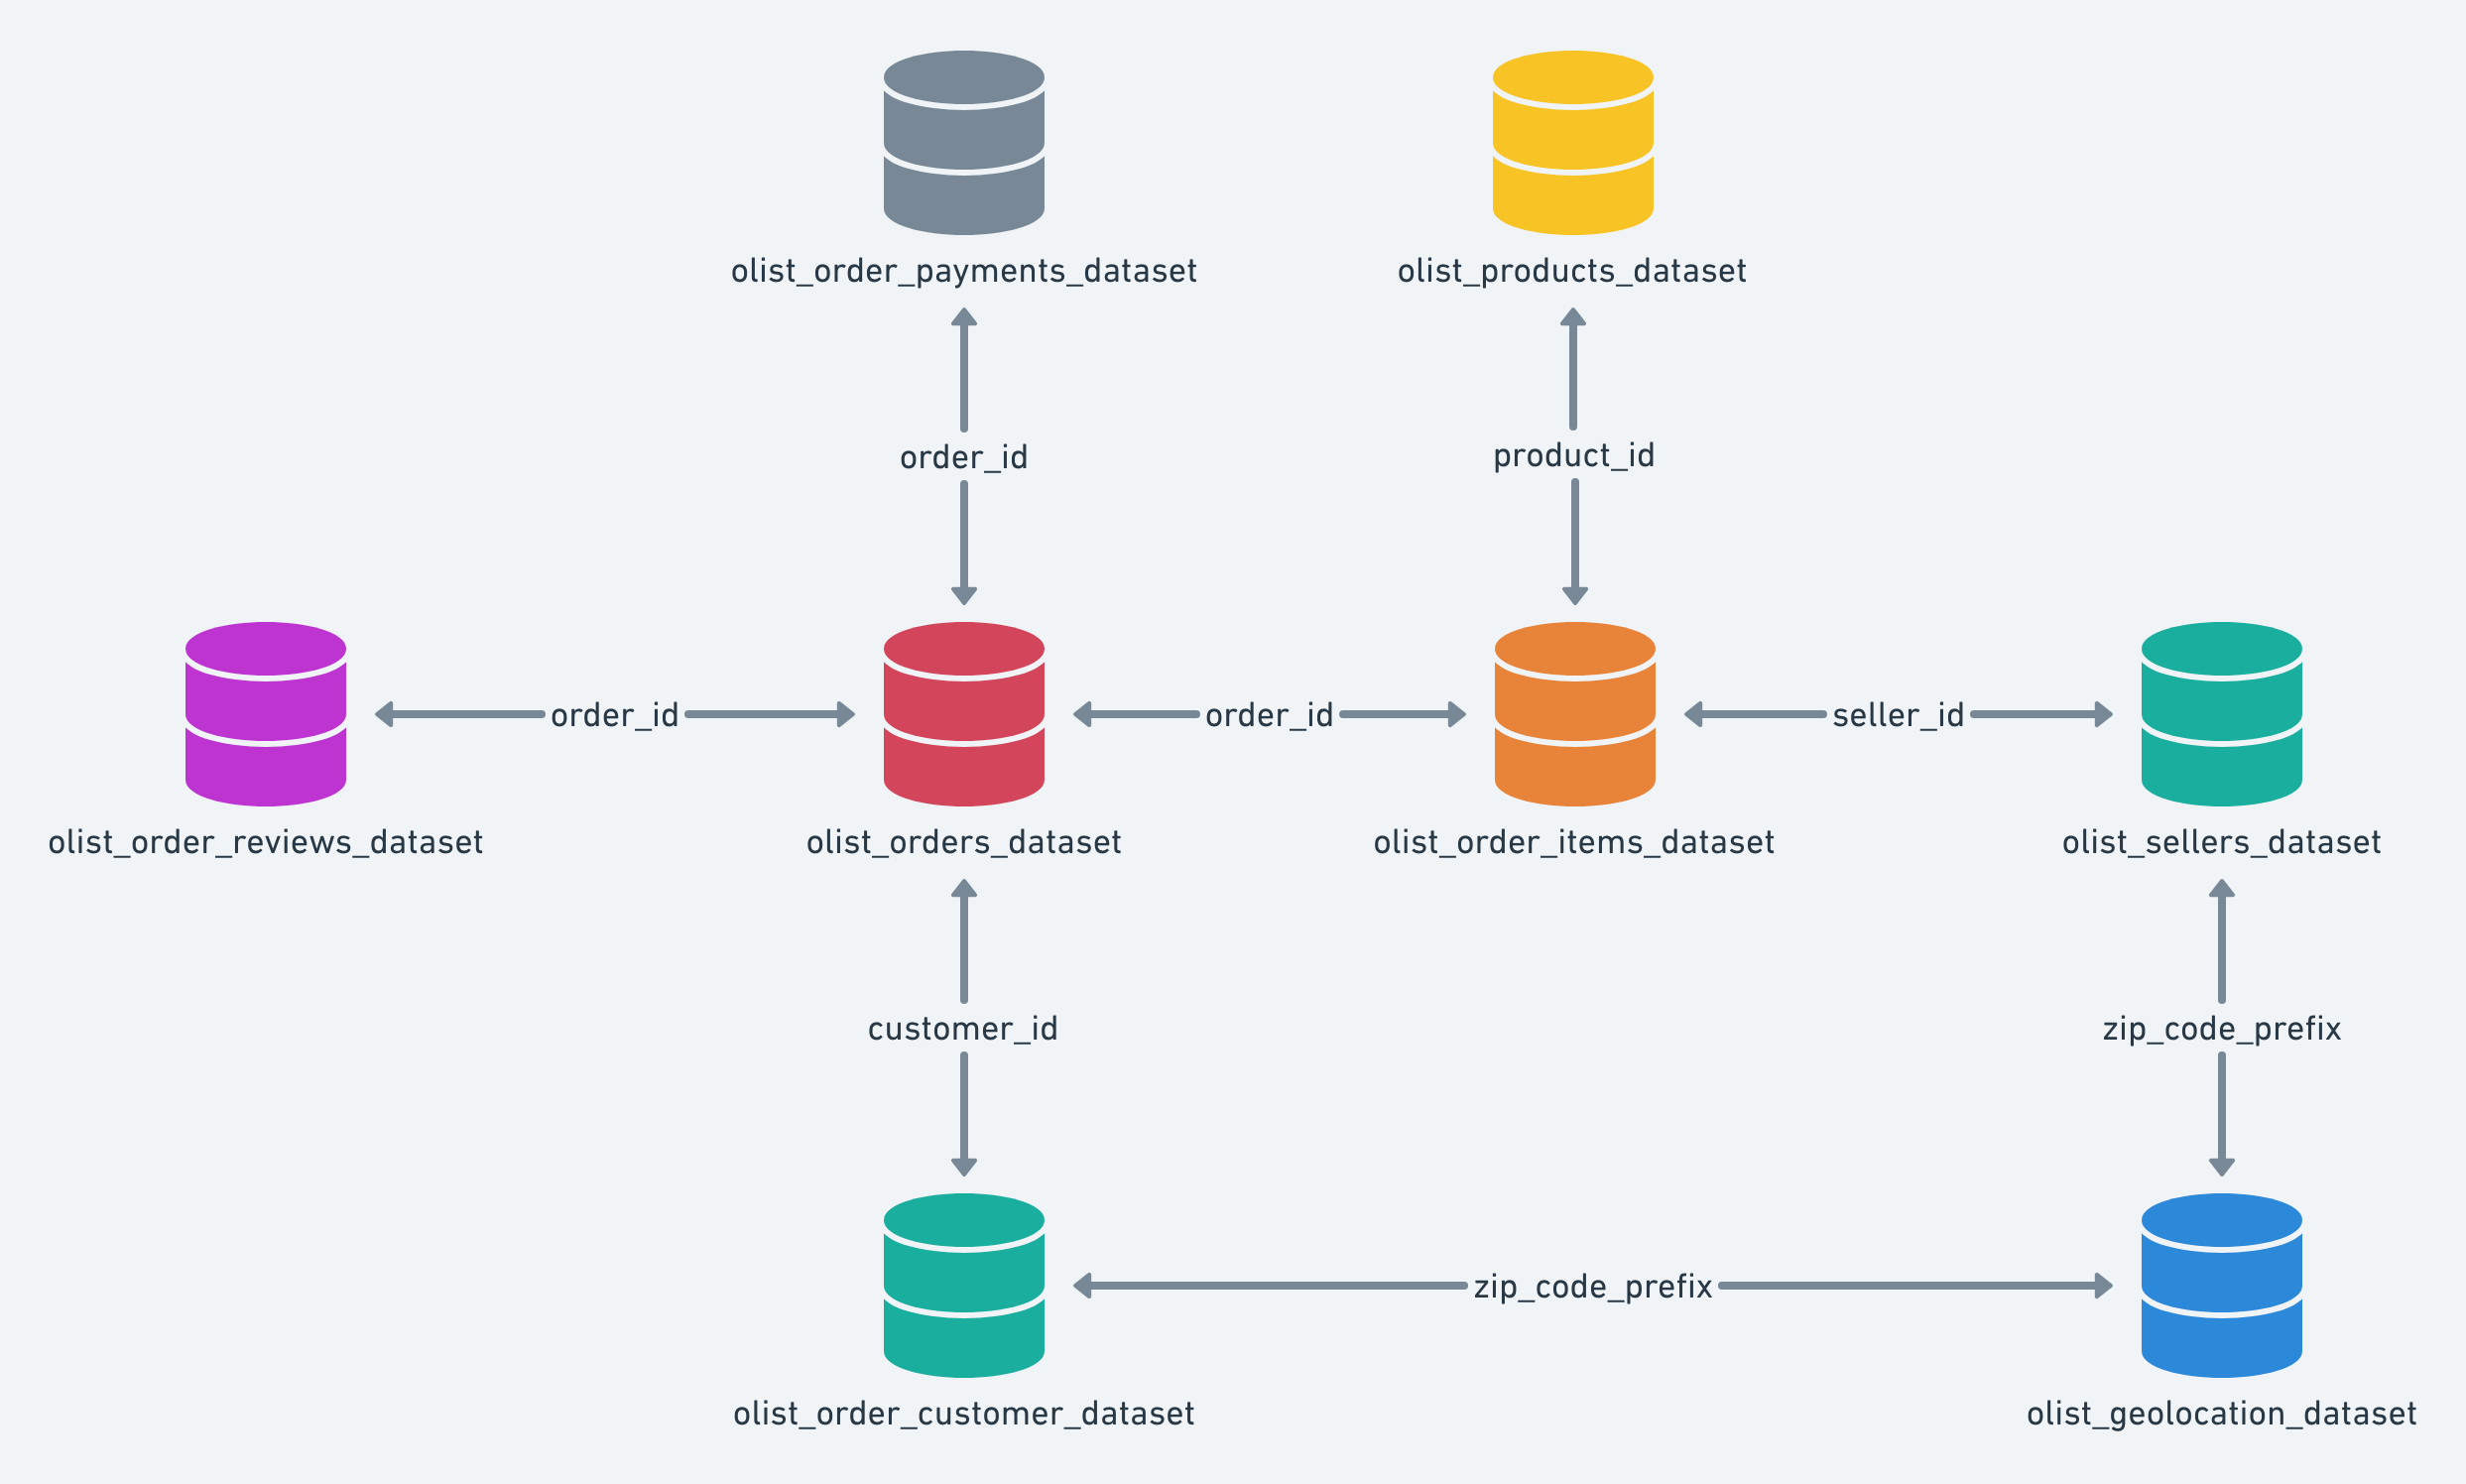

In [175]:
Image("HRhd2Y0.png")

In [176]:
load_dotenv()

conn = pymysql.connect(
    host=os.getenv("DB_HOST"),
    port=int(os.getenv("DB_PORT")),
    user=os.getenv("DB_USER"),
    password=os.getenv("DB_PASSWORD"),
    database=os.getenv("DB_NAME")
)

In [177]:
cursor = conn.cursor(pymysql.cursors.DictCursor)

In [178]:
cursor.execute("SHOW TABLES;")
table_list = [row[f'Tables_in_{os.getenv("DB_NAME")}'] for row in cursor.fetchall()]
for table in table_list:
    print(f"Table: {table}")
    cursor.execute(f"SELECT * FROM {table} LIMIT 2;")
    df = pd.DataFrame(cursor.fetchall())
    display(df)

Table: customers


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,00012a2ce6f8dcda20d059ce98491703,248ffe10d632bebe4f7267f1f44844c9,06273,osasco,SP
1,000161a058600d5901f007fab4c27140,b0015e09bb4b6e47c52844fab5fb6638,35550,itapecerica,MG


Table: geolocation


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,col_id
0,1037,-23.5456,-46.6393,sao paulo,SP,1
1,1046,-23.5461,-46.6448,sao paulo,SP,2


Table: order_items


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,col_id
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,1
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93,2


Table: order_payments


,order_id,payment_sequential,payment_type,payment_installments,payment_value,col_id
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,1
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39,2


Table: order_reviews


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,col_id
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,None,None,2018-01-18,2018-01-18 21:46:59,1
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,None,None,2018-03-10,2018-03-11 03:05:13,2


Table: orders


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,00010242fe8c5a6d1ba2dd792cb16214,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29
1,00018f77f2f0320c557190d7a144bdd3,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15


Table: product_category_name


,product_category_name,product_category_name_english
0,agro_industria_e_comercio,agro_industry_and_commerce
1,alimentos,food


Table: products


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,col_id
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40,287,1,225,16,10,14,1
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44,276,1,1000,30,18,20,2


Table: sellers


,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,0015a82c2db000af6aaaf3ae2ecb0532,9080,santo andre,SP
1,001cca7ae9ae17fb1caed9dfb1094831,29156,cariacica,ES


In [179]:
query = """
SELECT
    c.customer_unique_id AS customer_id,
    o.order_id,
    o.order_purchase_timestamp,
    p.payment_value
FROM
    orders AS o
JOIN customers AS c ON o.customer_id = c.customer_id
JOIN order_payments AS p ON o.order_id = p.order_id
WHERE
    o.order_status = 'delivered';
"""

In [180]:
cursor.execute(query)
result = cursor.fetchall()
df = pd.DataFrame(result)

In [181]:
df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"])
order_payment = df.groupby("order_id")["payment_value"].sum().reset_index()
df = df.drop(columns=["payment_value"]).drop_duplicates(subset=["order_id"])
df = df.merge(order_payment, on="order_id", how="left")

In [182]:
# RFM
NOW = df["order_purchase_timestamp"].max().normalize() + pd.Timedelta(days=1)

rfm = df.groupby("customer_id").agg({
    "order_purchase_timestamp": [
        lambda x: (NOW - x.max()).days,   # Recency
        "count",   # Frequency
    ],
    "payment_value": "sum"   # Monetary
})
rfm.columns = ["Recency", "Frequency", "Monetary"]
rfm = rfm.reset_index()

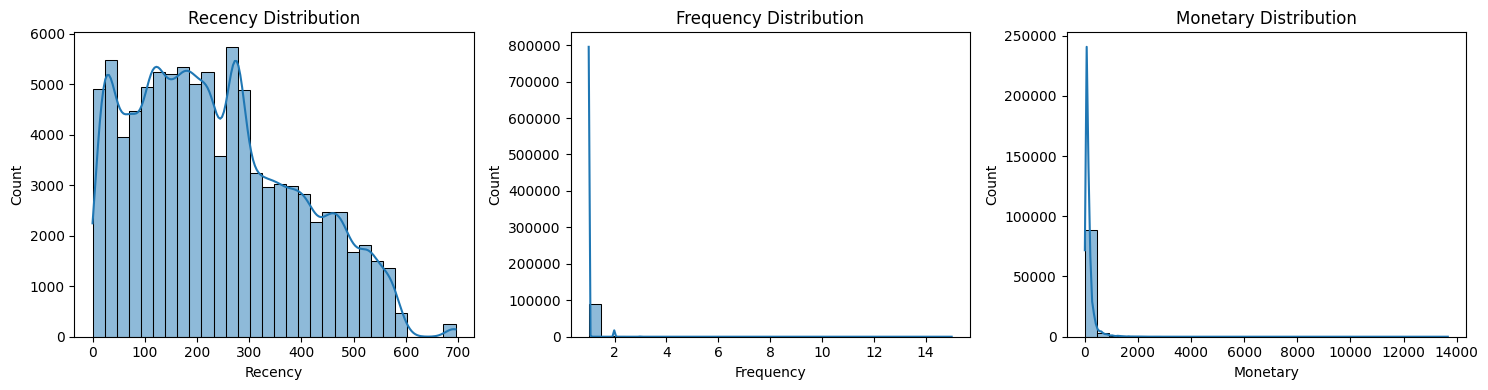

In [183]:
plt.figure(figsize=(15, 4))
for i, col in enumerate(["Recency", "Frequency", "Monetary"]):
    plt.subplot(1, 3, i + 1)
    sns.histplot(rfm[col], bins=30, kde=True)
    plt.title(f"{col} Distribution")
plt.tight_layout()
plt.show()

In [184]:
display(len(rfm))
rfm = rfm[rfm["Frequency"] > 1]
display(len(rfm))
rfm = rfm[rfm['Frequency'] > 2]
display(len(rfm))
rfm.head(2)

93357

2801

228

,customer_id,Recency,Frequency,Monetary
1069,02e9109b7e0a985108b43e573b6afb23,107,3,602.73
1498,041caba6a63ace5818387698ea85cdb2,97,3,153.46


In [185]:
def execute_query(query):
    cursor.execute(query)
    result = cursor.fetchall()
    return pd.DataFrame(result)

In [186]:
df = execute_query("""
select * from orders where order_status != 'canceled'
""")
df.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,00010242fe8c5a6d1ba2dd792cb16214,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29
1,00018f77f2f0320c557190d7a144bdd3,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15


In [187]:
df = execute_query("""
select order_id, oi.product_id, seller_id, price, freight_value, product_category_name_english
from order_items oi
join products p on oi.product_id = p.product_id
join product_category_name pcn on p.product_category_name = pcn.product_category_name
where order_id in (select order_id from orders where order_status != 'canceled') 
""")
df.head(2)

,order_id,product_id,seller_id,price,freight_value,product_category_name_english
0,0009792311464db532ff765bf7b182ae,8cab8abac59158715e0d70a36c807415,530ec6109d11eaaf87999465c6afee01,99.9,27.65,sports_leisure
1,000c3e6612759851cc3cbb4b83257986,b50c950aba0dcead2c48032a690ce817,218d46b86c1881d022bce9c68a7d4b15,99.0,13.71,sports_leisure


In [188]:
df['order_id'].value_counts().head(10)

order_id
8272b63d03f5f79c56e9e4120aec44ef    21
1b15974a0141d54e36626dca3fdc731a    20
ab14fdcfbe524636d65ee38360e22ce8    20
9ef13efd6949e4573a18964dd1bbe7f5    15
428a2f660dc84138d969ccd69a0ab6d5    15
73c8ab38f07dc94389065f7eba4f297a    14
9bdc4d4c71aa1de4606060929dee888c    14
37ee401157a3a0b28c9c6d0ed8c3b24b    13
c05d6a79e55da72ca780ce90364abed9    12
3a213fcdfe7d98be74ea0dc05a8b31ae    12
Name: count, dtype: int64

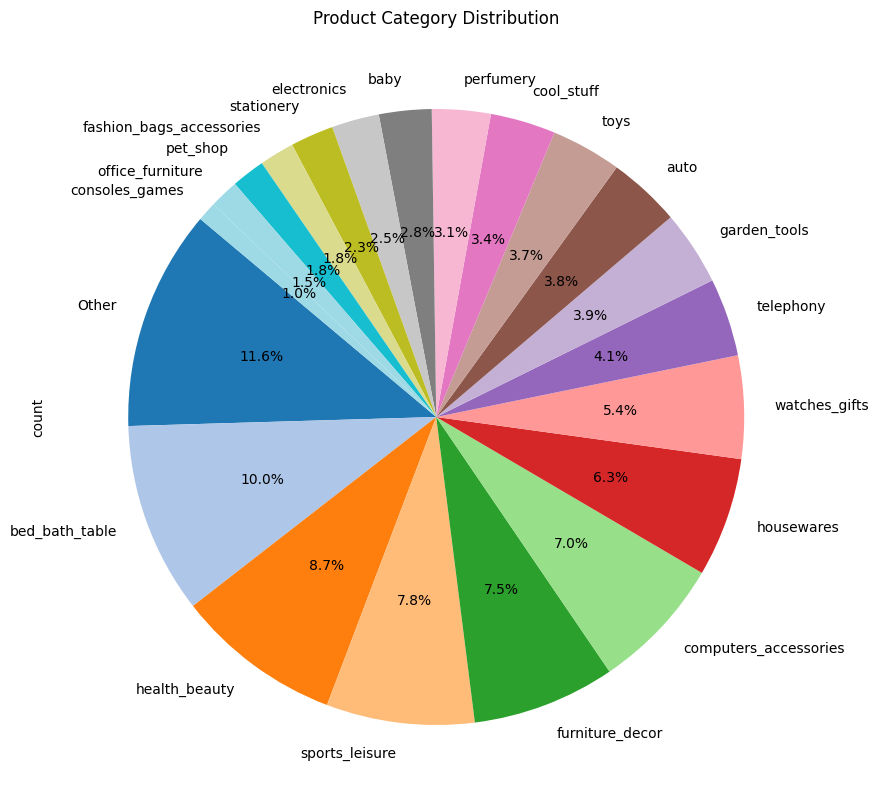

In [189]:
category_counts = df['product_category_name_english'].value_counts(normalize=True)
other = category_counts[category_counts <= 0.01].index
df_plot = df.copy()
df_plot['category_grouped'] = df_plot['product_category_name_english'].apply(lambda x: 'Other' if x in other else x)

plt.figure(figsize=(10, 10))
df_plot['category_grouped'].value_counts().plot.pie(autopct='%1.1f%%', startangle=140, cmap='tab20')
plt.title('Product Category Distribution')
plt.show()

In [190]:
a = execute_query("""
select
    oi.seller_id, sum(oi.price) as total_sales
from order_items oi
group by oi.seller_id
""")
display(a.sort_values(by='total_sales', ascending=False).head(5))
display(a['total_sales'].describe())

,seller_id,total_sales
87,4869f7a5dfa277a7dca6462dcf3b52b2,229472.628349
196,53243585a1d6dc2643021fd1853d8905,222776.049545
12,4a3ca9315b744ce9f8e9374361493884,200472.921459
259,fa1c13f2614d7b5c4749cbc52fecda94,194042.029396
21,7c67e1448b00f6e969d365cea6b010ab,187923.891939


count      3095.000000
mean       4391.484233
std       13921.997191
min           3.500000
25%         208.849998
50%         821.479998
75%        3280.830006
max      229472.628349
Name: total_sales, dtype: float64

In [191]:
seller = execute_query("""
with SellerCategorySales as (
    select
        oi.seller_id,
        sum(oi.price) as total_sales,
        p.product_category_name as category,
        count(oi.order_item_id) as sales_count
    from
        order_items oi
    join
        products p on oi.product_id = p.product_id
    group by
        oi.seller_id, p.product_category_name
)
select
    seller_id,
    product_category_name_english as category_name,
    sales_count,
    total_sales
from (
    select
        seller_id,
        category,
        total_sales,
        sales_count,
        rank() over (partition by seller_id order by sales_count desc) as category_rank
    from
        SellerCategorySales
) as sale_rank
left outer join product_category_name pcn on sale_rank.category = pcn.product_category_name
where
    category_rank = 1
""")
display(seller.sort_values(by='total_sales', ascending=False).head(5))

,seller_id,category_name,sales_count,total_sales
895,4869f7a5dfa277a7dca6462dcf3b52b2,watches_gifts,1002,201071.728630
3153,fa1c13f2614d7b5c4749cbc52fecda94,watches_gifts,579,192092.739418
1607,7c67e1448b00f6e969d365cea6b010ab,office_furniture,1233,172959.661690
1632,7e93a43ef30c4f03f38b393420bc753a,watches_gifts,314,169768.059258
920,4a3ca9315b744ce9f8e9374361493884,bed_bath_table,1572,165219.251059


In [192]:
top_sellers = np.quantile(a['total_sales'], 0.90)
seller_top = seller[seller['total_sales'] > top_sellers]

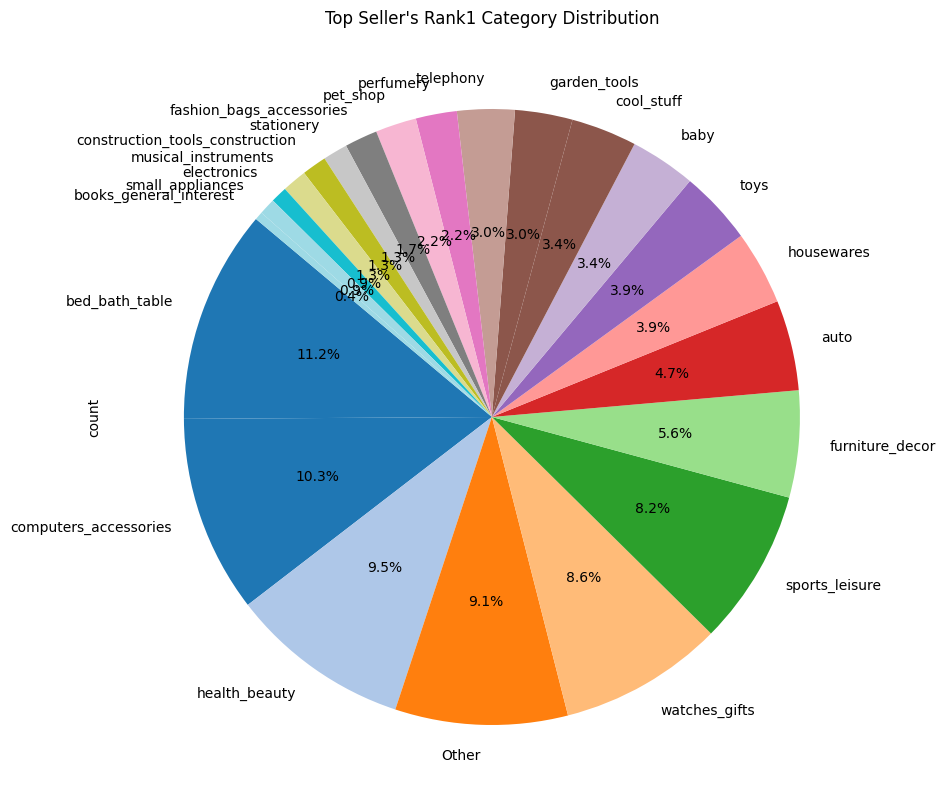

In [193]:
category_counts = seller['category_name'].value_counts(normalize=True)
other = category_counts[category_counts <= 0.01].index
df_plot = seller_top.copy()
df_plot['category_grouped'] = df_plot['category_name'].apply(lambda x: 'Other' if x in other else x)

plt.figure(figsize=(10, 10))
df_plot['category_grouped'].value_counts().plot.pie(autopct='%1.1f%%', startangle=140, cmap='tab20')
plt.title('Top Seller\'s Rank1 Category Distribution')
plt.show()

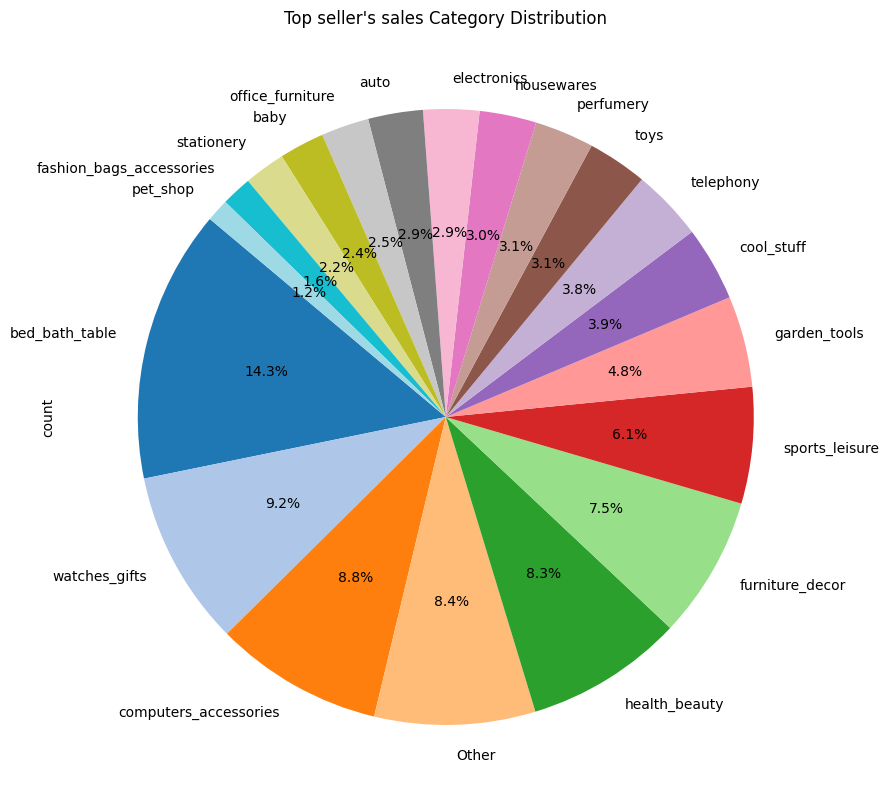

In [194]:
top_df = df[df['seller_id'].isin(seller_top['seller_id'])]
category_counts = top_df['product_category_name_english'].value_counts(normalize=True)
other = category_counts[category_counts <= 0.01].index
df_plot = top_df.copy()
df_plot['category_grouped'] = df_plot['product_category_name_english'].apply(lambda x: 'Other' if x in other else x)

plt.figure(figsize=(10, 10))
df_plot['category_grouped'].value_counts().plot.pie(autopct='%1.1f%%', startangle=140, cmap='tab20')
plt.title('Top seller\'s sales Category Distribution')
plt.show()

In [198]:
df.head(2)

,order_id,product_id,seller_id,price,freight_value,product_category_name_english
0,0009792311464db532ff765bf7b182ae,8cab8abac59158715e0d70a36c807415,530ec6109d11eaaf87999465c6afee01,99.9,27.65,sports_leisure
1,000c3e6612759851cc3cbb4b83257986,b50c950aba0dcead2c48032a690ce817,218d46b86c1881d022bce9c68a7d4b15,99.0,13.71,sports_leisure


In [195]:
# conn.close()